<a href="https://colab.research.google.com/github/chorltonm/fa_cup_upsets/blob/main/rating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
#import pandas_gbq


from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

In [ ]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
# os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')


# Import user defined python functions
import model_evaluation_functions
import ratings_functions
importlib.reload(model_evaluation_functions)
importlib.reload(ratings_functions)

from ratings_functions import *
from model_evaluation_functions import *


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [ ]:
# FA Cup Data 13 season from 08/09 to 21/20

fa_cup_scores = """
    select * from preparation_layer.view_fa_cup_scores order by sort_order ASC
"""

fa_cup_scores_df = client.query(fa_cup_scores).to_dataframe()
display(fa_cup_scores_df)

# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)
#def create_all_ranks_df():
 #   global all_ranks_df
  #  all_ranks_df = pd.DataFrame(columns=['team_no'])

#create_all_ranks_df()
#display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)



,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count
0,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1
1,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1
2,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1
3,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1
4,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,475990,2010-01-19,58,Accrington Stanley,4,1,54,Gillingham,3,0,58,54,1,0,1,54,1
301,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1
302,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1
303,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1


,team_no,fold_number


,metric_id,metric


Fold 1/5
Train data size: 244
Test data size: 61
basic_position
<function basic_position_ratings at 0x7bfcd0a4ac20>
[(1, 1.0), (2, 0.5), (3, 0.3333333333333333), (4, 0.25), (5, 0.2), (6, 0.16666666666666666), (7, 0.14285714285714285), (8, 0.125), (9, 0.1111111111111111), (10, 0.1), (11, 0.09090909090909091), (12, 0.08333333333333333), (13, 0.07692307692307693), (14, 0.07142857142857142), (15, 0.06666666666666667), (16, 0.0625), (17, 0.058823529411764705), (18, 0.05555555555555555), (19, 0.05263157894736842), (20, 0.05), (21, 0.047619047619047616), (22, 0.045454545454545456), (23, 0.043478260869565216), (24, 0.041666666666666664), (25, 0.04), (26, 0.038461538461538464), (27, 0.037037037037037035), (28, 0.03571428571428571), (29, 0.034482758620689655), (30, 0.03333333333333333), (31, 0.03225806451612903), (32, 0.03125), (33, 0.030303030303030304), (34, 0.029411764705882353), (35, 0.02857142857142857), (36, 0.027777777777777776), (37, 0.02702702702702703), (38, 0.02631578947368421), (39, 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,basic_position,1,1428623,27,2,1,1,0.037037,1.000000,1,1,0,0
2,basic_position,1,957292,2,1,22,2,0.500000,0.045455,2,2,0,0
3,basic_position,1,846113,2,1,42,2,0.500000,0.023810,2,2,0,0
4,basic_position,1,192160,2,1,41,2,0.500000,0.024390,2,2,0,0
5,basic_position,1,883278,3,1,33,2,0.333333,0.030303,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,basic_position,5,1349449,61,5,46,3,0.016393,0.021739,46,46,0,0
302,basic_position,5,472572,47,3,64,6,0.021277,0.015625,47,47,0,0
303,basic_position,5,846034,47,3,63,5,0.021277,0.015873,47,47,0,0
304,basic_position,5,475990,58,4,54,3,0.017241,0.018519,54,58,1,0


,accuracy
1,0.737705
2,0.737705
3,0.737705
4,0.721311
5,0.721311


,ratings_model,fold_number,team_no,rating,rank
320,basic_position,0,1,1.000000,1
0,basic_position,1,1,1.000000,1
4,basic_position,2,1,1.000000,1
2,basic_position,3,1,1.000000,1
1,basic_position,4,1,1.000000,1
...,...,...,...,...,...
317,basic_position,1,64,0.015625,64
316,basic_position,2,64,0.015625,64
318,basic_position,3,64,0.015625,64
315,basic_position,4,64,0.015625,64


Mean Upset Accuracy: 0.7311
Standard Deviation of Upset Accuracy: 0.0080
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,1
4,1,4,1
...,...,...,...
379,64,1,64
380,64,2,64
381,64,3,64
382,64,4,64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Cross-validation Accuracy,0.731
1,2,Overall Accuracy,0.731
2,3,Confusion Matrix - True Negative (Class 0),223.000
3,4,Confusion Matrix - False Positive (Class 1),0.000
4,5,Confusion Matrix - False Negative (Class 0),82.000
5,6,Confusion Matrix - True Positive (Class 1),0.000
6,7,Precision (Class 0),0.731
7,8,Recall (Class 0),1.000
8,9,F1-score (Class 0),0.845
9,10,Precision (Class 1),0.000


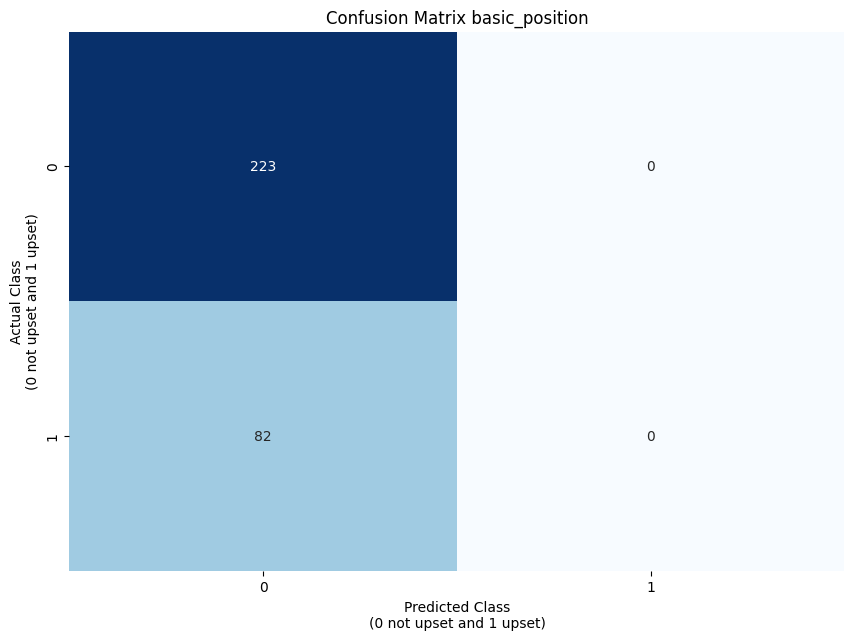

In [ ]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = basic_position_ratings
num_folds = 5

# Call ratings function and run cross validation

results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)


# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
Train data size: 244
Test data size: 61
massey
<function massey_ratings at 0x7bfcd0a48ca0>
244
[(1, 3.4966009636442), (2, 2.459050918226195), (3, 2.6785374822811283), (4, 2.152668152035571), (5, 1.7250383484627898), (6, 1.1103198095209037), (7, -0.2567715748608188), (8, 0.11027610544844983), (9, 2.2674782447626507), (10, 1.077207286261299), (11, -0.06934063712885567), (12, 0.6297166114036312), (13, 0.6808423116202914), (14, 1.0242655849519913), (15, 1.1150485641338044), (16, -0.0641642171781591), (17, 0.15039002608531638), (18, 0.28276451249031426), (19, -0.5943639870794029), (20, 1.5169348380544327), (21, -0.5331058849499194), (22, -0.0724864411056905), (23, -1.3587979583201413), (24, 0.9815329765734451), (25, 1.6723482766615008), (26, -0.6429797440523908), (27, 0.5078282128312593), (28, 1.56703659464498), (29, -1.802472459143607), (30, 0.776491824178764), (31, -0.289066311967068), (32, 0.7574635426468873), (33, 0.3538609243040879), (34, -0.15980327893468177), (35, -1.3497444

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,massey,1,1428623,27,2,1,1,0.507828,3.496601,1,1,0,0
2,massey,1,957292,2,1,22,2,2.459051,-0.072486,2,2,0,0
3,massey,1,846113,2,1,42,2,2.459051,-0.196505,2,2,0,0
4,massey,1,192160,2,1,41,2,2.459051,0.242015,2,2,0,0
5,massey,1,883278,3,1,33,2,2.678537,0.353861,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,massey,5,1349449,61,5,46,3,-1.204675,1.117069,46,46,0,0
302,massey,5,472572,47,3,64,6,0.147395,-0.900003,47,47,0,0
303,massey,5,846034,47,3,63,5,0.147395,-1.918144,47,47,0,0
304,massey,5,475990,58,4,54,3,-0.753261,-0.565395,54,58,1,0


,accuracy
1,0.721311
2,0.655738
3,0.704918
4,0.721311
5,0.721311


,ratings_model,fold_number,team_no,rating,rank
320,massey,0,1,3.559908,1
0,massey,1,1,3.496601,1
4,massey,2,1,3.081205,1
2,massey,3,1,3.548880,1
1,massey,4,1,3.899909,1
...,...,...,...,...,...
317,massey,1,64,-1.375727,59
316,massey,2,64,-1.147045,53
318,massey,3,64,-1.831059,60
315,massey,4,64,-1.328325,57


Mean Upset Accuracy: 0.7049
Standard Deviation of Upset Accuracy: 0.0254
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey
0,1,0,1,1
1,1,1,1,1
2,1,2,1,1
3,1,3,1,1
4,1,4,1,1
...,...,...,...,...
379,64,1,64,59
380,64,2,64,53
381,64,3,64,60
382,64,4,64,57


,metric_id,metric,basic_position,massey
0,1,Cross-validation Accuracy,0.731,0.705
1,2,Overall Accuracy,0.731,0.705
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000
6,7,Precision (Class 0),0.731,0.767
7,8,Recall (Class 0),1.000,0.857
8,9,F1-score (Class 0),0.845,0.809
9,10,Precision (Class 1),0.000,0.429


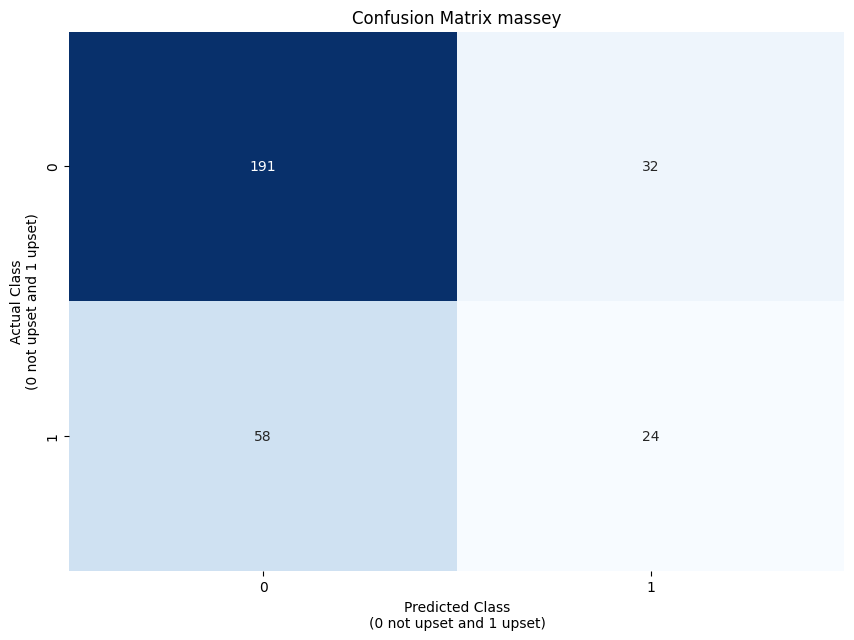

In [ ]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = massey_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 244
Test data size: 61
colley
<function colley_ratings at 0x7bfcd0a4a200>
244
[(1, 0.8498911477066322), (2, 0.7554168547295301), (3, 0.8680562660610066), (4, 0.8352419714143408), (5, 0.8197573209284842), (6, 0.6679503240309873), (7, 0.48073770742258193), (8, 0.6337052185163387), (9, 0.8365870746853525), (10, 0.7351893344911811), (11, 0.5803456026253193), (12, 0.6860889676553064), (13, 0.6925057531819149), (14, 0.6599594010210718), (15, 0.748440295704277), (16, 0.4925310298573109), (17, 0.5961828934372624), (18, 0.5290395891228444), (19, 0.380422364116023), (20, 0.7130884791676154), (21, 0.3060581807281239), (22, 0.5344623802879368), (23, 0.3668340496132292), (24, 0.5248683220034358), (25, 0.6966154651131808), (26, 0.2659675764068514), (27, 0.5812699747936496), (28, 0.9095356032978023), (29, 0.18202920957292018), (30, 0.5628300808516437), (31, 0.38228037997844394), (32, 0.5449372712688145), (33, 0.4840720953199818), (34, 0.4611198895679634), (35, 0.323107201230

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,colley,1,1428623,27,2,1,1,0.581270,0.849891,1,1,0,0
2,colley,1,957292,2,1,22,2,0.755417,0.534462,2,2,0,0
3,colley,1,846113,2,1,42,2,0.755417,0.425239,2,2,0,0
4,colley,1,192160,2,1,41,2,0.755417,0.612553,2,2,0,0
5,colley,1,883278,3,1,33,2,0.868056,0.484072,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,colley,5,1349449,61,5,46,3,0.245966,0.688995,46,46,0,0
302,colley,5,472572,47,3,64,6,0.424035,0.293456,47,47,0,0
303,colley,5,846034,47,3,63,5,0.424035,0.221318,47,47,0,0
304,colley,5,475990,58,4,54,3,0.488300,0.403912,58,58,1,1


,accuracy
1,0.688525
2,0.639344
3,0.704918
4,0.704918
5,0.770492


,ratings_model,fold_number,team_no,rating,rank
320,colley,0,1,0.880761,1
0,colley,1,1,0.849891,3
4,colley,2,1,0.919811,1
2,colley,3,1,0.857751,2
1,colley,4,1,0.921858,1
...,...,...,...,...,...
317,colley,1,64,0.165630,64
316,colley,2,64,0.189935,63
318,colley,3,64,0.138934,64
315,colley,4,64,0.190902,63


Mean Upset Accuracy: 0.7016
Standard Deviation of Upset Accuracy: 0.0420
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley
0,1,0,1,1,1
1,1,1,1,1,3
2,1,2,1,1,1
3,1,3,1,1,2
4,1,4,1,1,1
...,...,...,...,...,...
379,64,1,64,59,64
380,64,2,64,53,63
381,64,3,64,60,64
382,64,4,64,57,63


,metric_id,metric,basic_position,massey,colley
0,1,Cross-validation Accuracy,0.731,0.705,0.702
1,2,Overall Accuracy,0.731,0.705,0.702
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000,186.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000,37.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000
6,7,Precision (Class 0),0.731,0.767,0.775
7,8,Recall (Class 0),1.000,0.857,0.834
8,9,F1-score (Class 0),0.845,0.809,0.803
9,10,Precision (Class 1),0.000,0.429,0.431


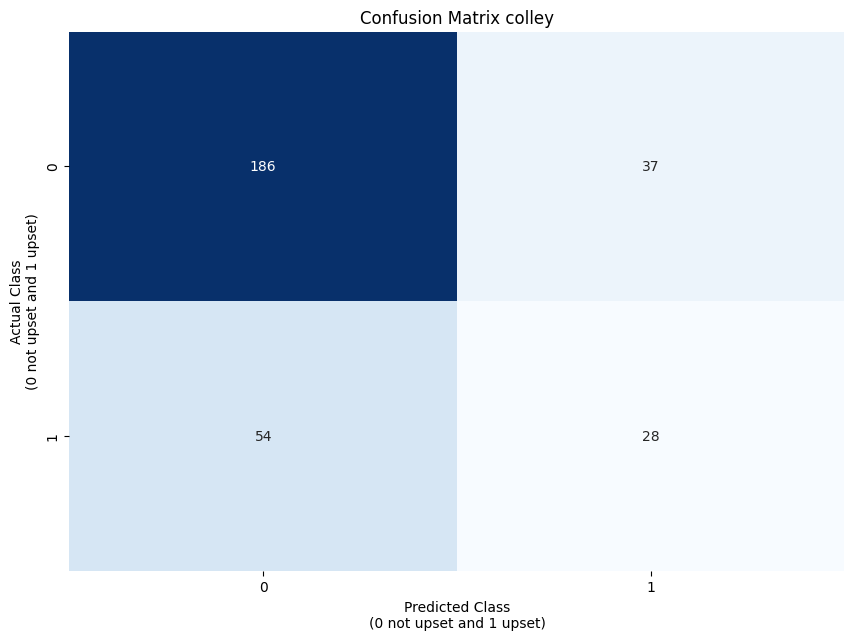

In [ ]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = colley_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
Train data size: 244
Test data size: 61
keener
<function keener_ratings at 0x7bfcd0a497e0>
[(1, 0.12965096494438863), (2, 0.1332791925348562), (3, 0.13573061474014067), (4, 0.13599907853978788), (5, 0.13884944247680517), (6, 0.13206828489562658), (7, 0.1255432342733447), (8, 0.1297194494921236), (9, 0.13107051259660502), (10, 0.1310712513470605), (11, 0.128611159976797), (12, 0.13006066445310843), (13, 0.12681205581776261), (14, 0.1287359140658818), (15, 0.1292086245363506), (16, 0.12584548755207026), (17, 0.12760803951683863), (18, 0.13132352480948756), (19, 0.12496636273593162), (20, 0.12997850280670945), (21, 0.12258650151005084), (22, 0.12575670376735829), (23, 0.11946810274269326), (24, 0.126653847363295), (25, 0.13187555863299458), (26, 0.12061029982323739), (27, 0.12474968329958207), (28, 0.13174084300795194), (29, 0.1186452531371661), (30, 0.12582032401183443), (31, 0.11886211766905742), (32, 0.12404867115176313), (33, 0.12439090411115762), (34, 0.12486702843197386), (

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,keener,1,1428623,27,2,1,1,0.124750,0.129651,1,1,0,0
2,keener,1,957292,2,1,22,2,0.133279,0.125757,2,2,0,0
3,keener,1,846113,2,1,42,2,0.133279,0.124141,2,2,0,0
4,keener,1,192160,2,1,41,2,0.133279,0.125835,2,2,0,0
5,keener,1,883278,3,1,33,2,0.135731,0.124391,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,keener,5,1349449,61,5,46,3,0.117884,0.129202,46,46,0,0
302,keener,5,472572,47,3,64,6,0.123830,0.120818,47,47,0,0
303,keener,5,846034,47,3,63,5,0.123830,0.118964,47,47,0,0
304,keener,5,475990,58,4,54,3,0.125524,0.121076,58,58,1,1


,accuracy
1,0.754098
2,0.704918
3,0.721311
4,0.688525
5,0.754098


,ratings_model,fold_number,team_no,rating,rank
331,keener,0,1,0.130056,12
0,keener,1,1,0.129651,14
4,keener,2,1,0.129359,13
2,keener,3,1,0.130527,10
1,keener,4,1,0.129783,12
...,...,...,...,...,...
317,keener,1,64,0.120657,48
316,keener,2,64,0.119274,56
318,keener,3,64,0.121185,50
315,keener,4,64,0.119263,58


Mean Upset Accuracy: 0.7246
Standard Deviation of Upset Accuracy: 0.0262
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener
0,1,0,1,1,1,12
1,1,1,1,1,3,14
2,1,2,1,1,1,13
3,1,3,1,1,2,10
4,1,4,1,1,1,12
...,...,...,...,...,...,...
379,64,1,64,59,64,48
380,64,2,64,53,63,56
381,64,3,64,60,64,50
382,64,4,64,57,63,58


,metric_id,metric,basic_position,massey,colley,keener
0,1,Cross-validation Accuracy,0.731,0.705,0.702,0.725
1,2,Overall Accuracy,0.731,0.705,0.702,0.725
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000,186.000,199.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000,37.000,24.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000
6,7,Precision (Class 0),0.731,0.767,0.775,0.768
7,8,Recall (Class 0),1.000,0.857,0.834,0.892
8,9,F1-score (Class 0),0.845,0.809,0.803,0.826
9,10,Precision (Class 1),0.000,0.429,0.431,0.478


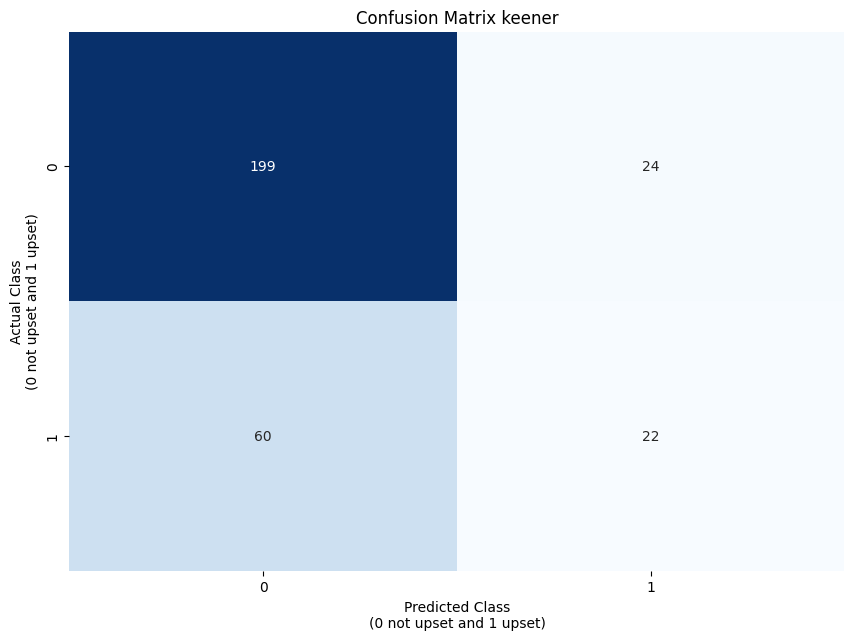

In [ ]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = keener_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 244
Test data size: 61
trueskill
<function trueskill_ratings at 0x7bfcd0a4b010>
[(60, 20.35798851230912), (63, 20.324484016298886), (56, 23.599892796817336), (6, 28.819067300497498), (13, 30.868660701676948), (41, 28.24324033113513), (39, 18.534437595593825), (48, 16.91829753825153), (62, 17.873970280212408), (38, 29.000379984203207), (33, 24.124020452431324), (9, 35.97793057768484), (34, 21.946179865328826), (59, 19.83337312586287), (30, 24.85693905144747), (55, 30.06520284163799), (10, 30.55482138488148), (36, 27.80169167845507), (50, 25.2926279747938), (18, 24.652991503690277), (5, 37.63396435143798), (35, 19.73486884873249), (43, 18.702603231095498), (2, 33.301747882195116), (54, 18.142087273961565), (4, 38.90070764517765), (19, 20.728319549607406), (57, 21.395420634927437), (31, 21.171240769198118), (47, 24.83086406803737), (20, 28.091983477751516), (28, 37.37758920524541), (45, 25.933735118038747), (49, 27.69284616605887), (3, 36.451027612114956), (42, 2

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,trueskill,1,1428623,27,2,1,1,28.280118,38.910802,1,1,0,0
2,trueskill,1,957292,2,1,22,2,33.301748,26.469186,2,2,0,0
3,trueskill,1,846113,2,1,42,2,33.301748,23.711914,2,2,0,0
4,trueskill,1,192160,2,1,41,2,33.301748,28.243240,2,2,0,0
5,trueskill,1,883278,3,1,33,2,36.451028,24.124020,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,trueskill,5,1349449,61,5,46,3,15.862753,28.725116,46,46,0,0
302,trueskill,5,472572,47,3,64,6,22.266791,18.503597,47,47,0,0
303,trueskill,5,846034,47,3,63,5,22.266791,18.557278,47,47,0,0
304,trueskill,5,475990,58,4,54,3,23.871779,22.670571,58,58,1,1


,accuracy
1,0.672131
2,0.639344
3,0.721311
4,0.721311
5,0.770492


,ratings_model,fold_number,team_no,rating,rank
320,trueskill,0,1,38.156533,1
1,trueskill,1,1,38.910802,1
0,trueskill,2,1,38.696935,1
3,trueskill,3,1,36.763833,2
4,trueskill,4,1,38.966714,1
...,...,...,...,...,...
316,trueskill,1,64,15.542639,62
319,trueskill,2,64,16.770261,59
315,trueskill,3,64,16.354213,62
317,trueskill,4,64,16.469389,61


Mean Upset Accuracy: 0.7049
Standard Deviation of Upset Accuracy: 0.0452
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill
0,1,0,1,1,1,12,1
1,1,1,1,1,3,14,1
2,1,2,1,1,1,13,1
3,1,3,1,1,2,10,2
4,1,4,1,1,1,12,1
...,...,...,...,...,...,...,...
379,64,1,64,59,64,48,62
380,64,2,64,53,63,56,59
381,64,3,64,60,64,50,62
382,64,4,64,57,63,58,61


,metric_id,metric,basic_position,massey,colley,keener,trueskill
0,1,Cross-validation Accuracy,0.731,0.705,0.702,0.725,0.705
1,2,Overall Accuracy,0.731,0.705,0.702,0.725,0.705
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000,186.000,199.000,181.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000,37.000,24.000,42.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,48.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,34.000
6,7,Precision (Class 0),0.731,0.767,0.775,0.768,0.790
7,8,Recall (Class 0),1.000,0.857,0.834,0.892,0.812
8,9,F1-score (Class 0),0.845,0.809,0.803,0.826,0.801
9,10,Precision (Class 1),0.000,0.429,0.431,0.478,0.447


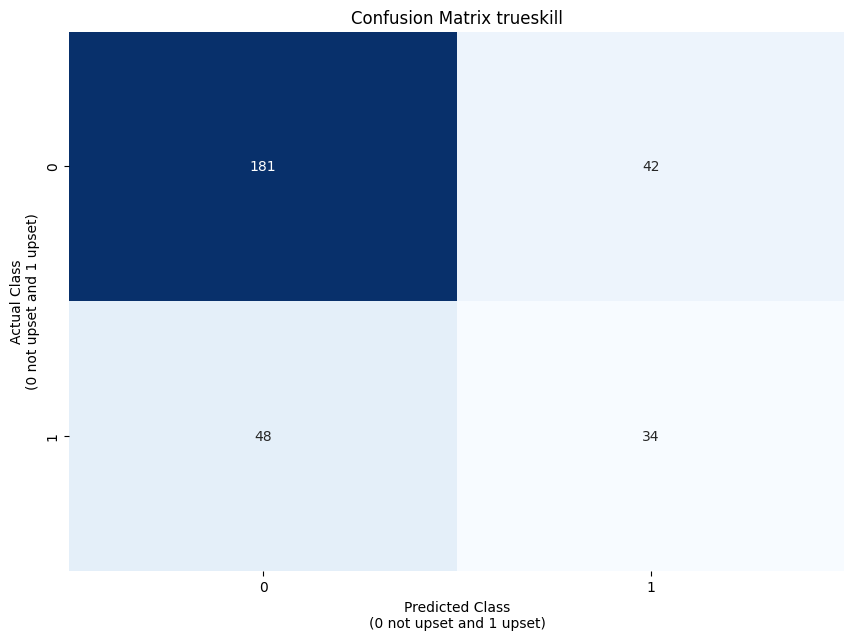

In [ ]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = trueskill_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



100%|██████████| 1/1 [00:00<00:00, 3847.99it/s]


In [ ]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


In [ ]:
# Local Kemeny Optimisation

#from google.cloud import bigquery
#from google.oauth2 import service_account
#import pandas as pd

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    #credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    rankings = {
        'basic_position': df['basic_position'].tolist(),
        'massey': df['massey'].tolist(),
        'colley': df['colley'].tolist(),
        'keener': df['keener'].tolist(),
        'trueskill': df['trueskill'].tolist()
    }

    # Use Borda count as initial ranking
    borda_count = df['borda_count_x'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimization(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # If you want to see which teams changed positions
    team_nos = df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


Fold 1/5
Train data size: 244
Test data size: 61
borda_count
<function borda_count_aggregation at 0x7bfccf9975b0>
[(1, 0.3333333333333333), (2, 0.2), (3, 1.0), (4, 0.5), (5, 0.25), (6, 0.125), (7, 0.03571428571428571), (8, 0.0625), (9, 0.16666666666666666), (10, 0.1111111111111111), (11, 0.058823529411764705), (12, 0.06666666666666667), (13, 0.07142857142857142), (14, 0.07692307692307693), (15, 0.1), (16, 0.034482758620689655), (17, 0.05555555555555555), (18, 0.05), (19, 0.027777777777777776), (20, 0.08333333333333333), (21, 0.024390243902439025), (22, 0.037037037037037035), (23, 0.022727272727272728), (24, 0.047619047619047616), (25, 0.09090909090909091), (26, 0.021739130434782608), (27, 0.045454545454545456), (28, 0.14285714285714285), (29, 0.017543859649122806), (30, 0.043478260869565216), (31, 0.023809523809523808), (32, 0.03333333333333333), (33, 0.03125), (34, 0.02857142857142857), (35, 0.02127659574468085), (36, 0.05263157894736842), (37, 0.022222222222222223), (38, 0.0384615384

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,borda_count,1,1428623,27,2,1,1,0.045455,0.333333,1,1,0,0
2,borda_count,1,957292,2,1,22,2,0.200000,0.037037,2,2,0,0
3,borda_count,1,846113,2,1,42,2,0.200000,0.025641,2,2,0,0
4,borda_count,1,192160,2,1,41,2,0.200000,0.041667,2,2,0,0
5,borda_count,1,883278,3,1,33,2,1.000000,0.031250,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,borda_count,5,1349449,61,5,46,3,0.016129,0.052632,46,46,0,0
302,borda_count,5,472572,47,3,64,6,0.029412,0.017241,47,47,0,0
303,borda_count,5,846034,47,3,63,5,0.029412,0.015873,47,47,0,0
304,borda_count,5,475990,58,4,54,3,0.026316,0.020408,58,58,1,1


,accuracy
1,0.754098
2,0.770492
3,0.770492
4,0.672131
5,0.803279


,ratings_model,fold_number,team_no,rating,rank
320,borda_count,0,1,0.566667,1
0,borda_count,1,1,0.333333,3
4,borda_count,2,1,1.000000,1
2,borda_count,3,1,0.500000,2
1,borda_count,4,1,0.500000,2
...,...,...,...,...,...
317,borda_count,1,64,0.015873,63
316,borda_count,2,64,0.016129,62
318,borda_count,3,64,0.015625,64
315,borda_count,4,64,0.015873,63


Mean Upset Accuracy: 0.7541
Standard Deviation of Upset Accuracy: 0.0440
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count
0,1,0,1,1,1,12,1,1
1,1,1,1,1,3,14,1,3
2,1,2,1,1,1,13,1,1
3,1,3,1,1,2,10,2,2
4,1,4,1,1,1,12,1,2
...,...,...,...,...,...,...,...,...
379,64,1,64,59,64,48,62,63
380,64,2,64,53,63,56,59,62
381,64,3,64,60,64,50,62,64
382,64,4,64,57,63,58,61,63


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
borda_count


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count
0,1,Cross-validation Accuracy,0.731,0.705,0.702,0.725,0.705,0.754
1,2,Overall Accuracy,0.731,0.705,0.702,0.725,0.705,0.754
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000,186.000,199.000,181.000,207.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000,37.000,24.000,42.000,16.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,48.000,59.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,34.000,23.000
6,7,Precision (Class 0),0.731,0.767,0.775,0.768,0.790,0.778
7,8,Recall (Class 0),1.000,0.857,0.834,0.892,0.812,0.928
8,9,F1-score (Class 0),0.845,0.809,0.803,0.826,0.801,0.847
9,10,Precision (Class 1),0.000,0.429,0.431,0.478,0.447,0.590


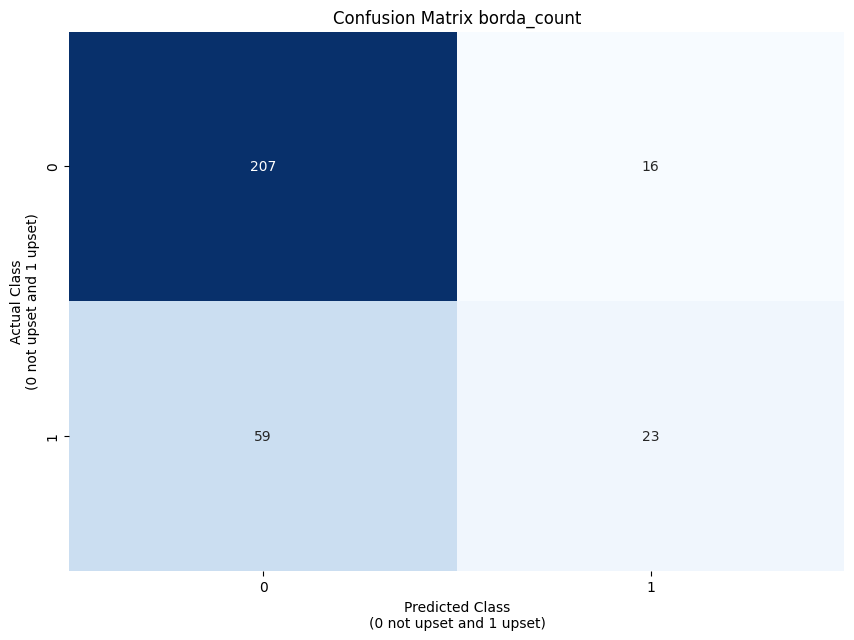

In [ ]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 244
Test data size: 61
average_rank
<function average_rank_aggregation at 0x7bfccf997400>


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
5,1,1,1,1,3,14,1,4.0,3,0.333333
8,2,1,2,3,7,4,8,4.8,5,0.200000
13,3,1,3,2,2,3,5,3.0,1,1.000000
22,4,1,4,5,5,2,2,3.6,2,0.500000
26,5,1,5,6,6,1,3,4.2,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
357,60,1,60,63,49,44,46,52.4,54,0.018519
364,61,1,61,56,60,62,61,60.0,64,0.015625
368,62,1,62,49,56,64,58,57.8,62,0.016129
373,63,1,63,61,50,55,47,55.2,58,0.017241


[(1, 0.3333333333333333), (2, 0.2), (3, 1.0), (4, 0.5), (5, 0.25), (6, 0.125), (7, 0.03571428571428571), (8, 0.0625), (9, 0.16666666666666666), (10, 0.1111111111111111), (11, 0.058823529411764705), (12, 0.06666666666666667), (13, 0.07142857142857142), (14, 0.07692307692307693), (15, 0.1), (16, 0.034482758620689655), (17, 0.05555555555555555), (18, 0.05), (19, 0.027777777777777776), (20, 0.08333333333333333), (21, 0.024390243902439025), (22, 0.037037037037037035), (23, 0.022727272727272728), (24, 0.047619047619047616), (25, 0.09090909090909091), (26, 0.021739130434782608), (27, 0.045454545454545456), (28, 0.14285714285714285), (29, 0.017543859649122806), (30, 0.043478260869565216), (31, 0.023809523809523808), (32, 0.03333333333333333), (33, 0.03125), (34, 0.02857142857142857), (35, 0.02127659574468085), (36, 0.05263157894736842), (37, 0.022222222222222223), (38, 0.038461538461538464), (39, 0.02), (40, 0.02631578947368421), (41, 0.041666666666666664), (42, 0.02564102564102564), (43, 0.01

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
1,1,2,1,1,1,13,1,3.4,1,1.000000
11,2,2,2,2,11,5,9,5.8,6,0.166667
14,3,2,3,3,3,10,6,5.0,4,0.250000
20,4,2,4,4,4,4,5,4.2,2,0.500000
28,5,2,5,9,8,1,3,5.2,5,0.200000
...,...,...,...,...,...,...,...,...,...,...
359,60,2,60,64,59,57,57,59.4,63,0.015873
360,61,2,61,51,43,61,52,53.6,55,0.018182
369,62,2,62,46,56,44,60,53.6,56,0.017857
376,63,2,63,63,60,58,58,60.4,64,0.015625


[(1, 1.0), (2, 0.16666666666666666), (3, 0.25), (4, 0.5), (5, 0.2), (6, 0.06666666666666667), (7, 0.025), (8, 0.1), (9, 0.05), (10, 0.3333333333333333), (11, 0.045454545454545456), (12, 0.14285714285714285), (13, 0.041666666666666664), (14, 0.058823529411764705), (15, 0.1111111111111111), (16, 0.07692307692307693), (17, 0.08333333333333333), (18, 0.07142857142857142), (19, 0.03225806451612903), (20, 0.125), (21, 0.024390243902439025), (22, 0.02564102564102564), (23, 0.02040816326530612), (24, 0.05555555555555555), (25, 0.09090909090909091), (26, 0.023809523809523808), (27, 0.038461538461538464), (28, 0.0625), (29, 0.023255813953488372), (30, 0.043478260869565216), (31, 0.017241379310344827), (32, 0.034482758620689655), (33, 0.029411764705882353), (34, 0.02631578947368421), (35, 0.0196078431372549), (36, 0.047619047619047616), (37, 0.03125), (38, 0.05263157894736842), (39, 0.030303030303030304), (40, 0.019230769230769232), (41, 0.02702702702702703), (42, 0.022222222222222223), (43, 0.01

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
4,1,3,1,1,2,10,2,3.2,2,0.500000
9,2,3,2,6,9,5,7,5.8,5,0.200000
17,3,3,3,2,5,7,5,4.4,3,0.333333
18,4,3,4,3,1,1,1,2.0,1,1.000000
27,5,3,5,7,6,3,3,4.8,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
354,60,3,60,58,45,41,44,49.6,49,0.020408
361,61,3,61,45,51,55,58,54.0,57,0.017544
367,62,3,62,53,55,61,56,57.4,62,0.016129
372,63,3,63,57,48,53,48,53.8,56,0.017857


[(1, 0.5), (2, 0.2), (3, 0.3333333333333333), (4, 1.0), (5, 0.25), (6, 0.07142857142857142), (7, 0.020833333333333332), (8, 0.1111111111111111), (9, 0.04), (10, 0.16666666666666666), (11, 0.058823529411764705), (12, 0.09090909090909091), (13, 0.14285714285714285), (14, 0.05555555555555555), (15, 0.125), (16, 0.05263157894736842), (17, 0.1), (18, 0.05), (19, 0.038461538461538464), (20, 0.07692307692307693), (21, 0.022727272727272728), (22, 0.02631578947368421), (23, 0.02702702702702703), (24, 0.043478260869565216), (25, 0.08333333333333333), (26, 0.025), (27, 0.037037037037037035), (28, 0.0625), (29, 0.027777777777777776), (30, 0.045454545454545456), (31, 0.018867924528301886), (32, 0.03333333333333333), (33, 0.029411764705882353), (34, 0.03571428571428571), (35, 0.02), (36, 0.06666666666666667), (37, 0.03125), (38, 0.041666666666666664), (39, 0.023809523809523808), (40, 0.02857142857142857), (41, 0.0196078431372549), (42, 0.01818181818181818), (43, 0.018518518518518517), (44, 0.0169491

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
2,1,4,1,1,1,12,1,3.2,2,0.500000
6,2,4,2,4,2,1,2,2.2,1,1.000000
15,3,4,3,3,3,4,3,3.2,3,0.333333
21,4,4,4,2,4,2,4,3.2,4,0.250000
29,5,4,5,5,8,3,7,5.6,5,0.200000
...,...,...,...,...,...,...,...,...,...,...
355,60,4,60,64,45,47,37,50.6,52,0.019231
363,61,4,61,52,57,59,59,57.6,62,0.016129
366,62,4,62,53,53,60,53,56.2,60,0.016667
375,63,4,63,62,59,50,51,57.0,61,0.016393


[(1, 0.5), (2, 1.0), (3, 0.3333333333333333), (4, 0.25), (5, 0.2), (6, 0.16666666666666666), (7, 0.023809523809523808), (8, 0.1), (9, 0.05263157894736842), (10, 0.14285714285714285), (11, 0.045454545454545456), (12, 0.1111111111111111), (13, 0.06666666666666667), (14, 0.05555555555555555), (15, 0.125), (16, 0.058823529411764705), (17, 0.07142857142857142), (18, 0.09090909090909091), (19, 0.02631578947368421), (20, 0.0625), (21, 0.025), (22, 0.027777777777777776), (23, 0.018867924528301886), (24, 0.043478260869565216), (25, 0.08333333333333333), (26, 0.022727272727272728), (27, 0.05), (28, 0.07692307692307693), (29, 0.020833333333333332), (30, 0.038461538461538464), (31, 0.021739130434782608), (32, 0.04), (33, 0.03333333333333333), (34, 0.02857142857142857), (35, 0.017543859649122806), (36, 0.047619047619047616), (37, 0.023255813953488372), (38, 0.041666666666666664), (39, 0.03125), (40, 0.02702702702702703), (41, 0.02564102564102564), (42, 0.02040816326530612), (43, 0.02127659574468085

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
3,1,5,1,1,1,10,1,2.8,2,0.500000
10,2,5,2,5,9,3,7,5.2,4,0.250000
16,3,5,3,2,4,5,3,3.4,3,0.333333
23,4,5,4,8,5,6,4,5.4,5,0.200000
24,5,5,5,3,2,1,2,2.6,1,1.000000
...,...,...,...,...,...,...,...,...,...,...
358,60,5,60,64,56,57,51,57.6,59,0.016949
365,61,5,61,57,61,61,62,60.4,62,0.016129
371,62,5,62,60,62,64,64,62.4,64,0.015625
377,63,5,63,62,64,59,58,61.2,63,0.015873


[(1, 0.5), (2, 0.25), (3, 0.3333333333333333), (4, 0.2), (5, 1.0), (6, 0.1), (7, 0.02702702702702703), (8, 0.125), (9, 0.047619047619047616), (10, 0.16666666666666666), (11, 0.06666666666666667), (12, 0.14285714285714285), (13, 0.058823529411764705), (14, 0.05555555555555555), (15, 0.1111111111111111), (16, 0.05), (17, 0.07692307692307693), (18, 0.04), (19, 0.030303030303030304), (20, 0.08333333333333333), (21, 0.022222222222222223), (22, 0.037037037037037035), (23, 0.02564102564102564), (24, 0.07142857142857142), (25, 0.09090909090909091), (26, 0.03333333333333333), (27, 0.03571428571428571), (28, 0.0625), (29, 0.020833333333333332), (30, 0.043478260869565216), (31, 0.018867924528301886), (32, 0.027777777777777776), (33, 0.023255813953488372), (34, 0.041666666666666664), (35, 0.017543859649122806), (36, 0.045454545454545456), (37, 0.018518518518518517), (38, 0.038461538461538464), (39, 0.022727272727272728), (40, 0.03225806451612903), (41, 0.025), (42, 0.02127659574468085), (43, 0.021

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,average_rank,1,1428623,27,2,1,1,0.045455,0.333333,1,1,0,0
2,average_rank,1,957292,2,1,22,2,0.200000,0.037037,2,2,0,0
3,average_rank,1,846113,2,1,42,2,0.200000,0.025641,2,2,0,0
4,average_rank,1,192160,2,1,41,2,0.200000,0.041667,2,2,0,0
5,average_rank,1,883278,3,1,33,2,1.000000,0.031250,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,average_rank,5,1349449,61,5,46,3,0.016129,0.052632,46,46,0,0
302,average_rank,5,472572,47,3,64,6,0.029412,0.017241,47,47,0,0
303,average_rank,5,846034,47,3,63,5,0.029412,0.015873,47,47,0,0
304,average_rank,5,475990,58,4,54,3,0.026316,0.020408,58,58,1,1


,accuracy
1,0.754098
2,0.770492
3,0.770492
4,0.672131
5,0.803279


,ratings_model,fold_number,team_no,rating,rank
320,average_rank,0,1,0.566667,1
0,average_rank,1,1,0.333333,3
4,average_rank,2,1,1.000000,1
2,average_rank,3,1,0.500000,2
1,average_rank,4,1,0.500000,2
...,...,...,...,...,...
317,average_rank,1,64,0.015873,63
316,average_rank,2,64,0.016129,62
318,average_rank,3,64,0.015625,64
315,average_rank,4,64,0.015873,63


Mean Upset Accuracy: 0.7541
Standard Deviation of Upset Accuracy: 0.0440
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,0,1,1,1,12,1,1,1
1,1,1,1,1,3,14,1,3,3
2,1,2,1,1,1,13,1,1,1
3,1,3,1,1,2,10,2,2,2
4,1,4,1,1,1,12,1,2,2
...,...,...,...,...,...,...,...,...,...
379,64,1,64,59,64,48,62,63,63
380,64,2,64,53,63,56,59,62,62
381,64,3,64,60,64,50,62,64,64
382,64,4,64,57,63,58,61,63,63


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
average_rank


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,Cross-validation Accuracy,0.731,0.705,0.702,0.725,0.705,0.754,0.754
1,2,Overall Accuracy,0.731,0.705,0.702,0.725,0.705,0.754,0.754
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000,186.000,199.000,181.000,207.000,207.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000,37.000,24.000,42.000,16.000,16.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,48.000,59.000,59.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,34.000,23.000,23.000
6,7,Precision (Class 0),0.731,0.767,0.775,0.768,0.790,0.778,0.778
7,8,Recall (Class 0),1.000,0.857,0.834,0.892,0.812,0.928,0.928
8,9,F1-score (Class 0),0.845,0.809,0.803,0.826,0.801,0.847,0.847
9,10,Precision (Class 1),0.000,0.429,0.431,0.478,0.447,0.590,0.590


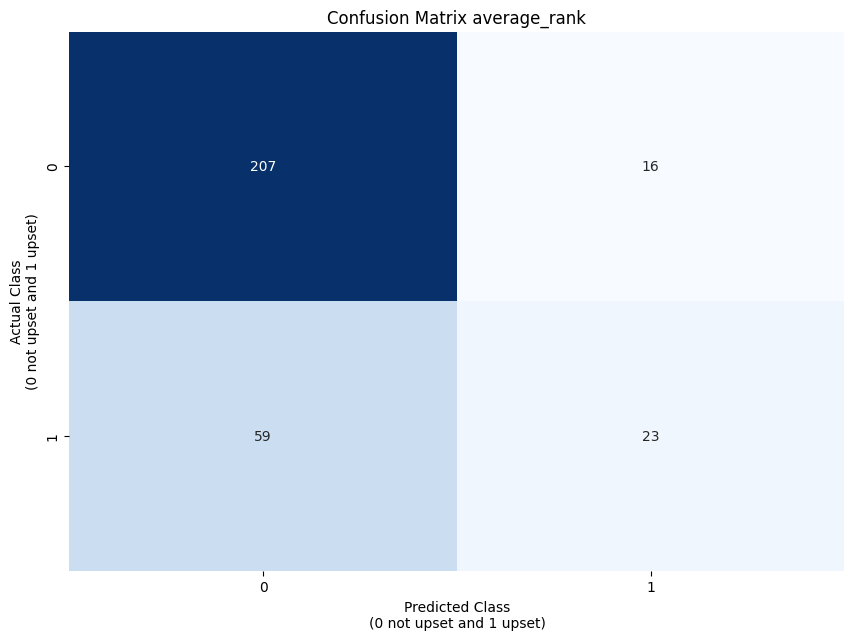

In [ ]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


Fold 1/5
Train data size: 244
Test data size: 61
local_kemeny_optimisation
<function local_kemeny_optimisation at 0x7bfcd0959510>
Iteration 1: Improved distance to 1100
Iteration 2: Improved distance to 1099
Iteration 3: Improved distance to 1096
Iteration 4: Improved distance to 1095
Stopped after 5 iterations: No improvement

Total Kendall tau distance (Borda Count): 1101
Total Kendall tau distance (Optimized): 1095

Teams that changed positions (Team, Old Position, New Position):
Team 2: 3 -> 2
Team 3: 2 -> 3
Team 15: 12 -> 13
Team 17: 13 -> 12
Team 37: 39 -> 38
Team 39: 38 -> 39
Team 56: 59 -> 58
Team 57: 58 -> 59
[(1, 1.0), (2, 0.2), (3, 0.5), (4, 0.3333333333333333), (5, 0.25), (6, 0.1111111111111111), (7, 0.02631578947368421), (8, 0.1), (9, 0.0625), (10, 0.16666666666666666), (11, 0.05263157894736842), (12, 0.125), (13, 0.058823529411764705), (14, 0.06666666666666667), (15, 0.14285714285714285), (16, 0.05), (17, 0.07142857142857142), (18, 0.05555555555555555), (19, 0.03225806451

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset
1,local_kemeny_optimisation,1,1428623,27,2,1,1,0.038462,1.000000,1,1,0,0
2,local_kemeny_optimisation,1,957292,2,1,22,2,0.200000,0.031250,2,2,0,0
3,local_kemeny_optimisation,1,846113,2,1,42,2,0.200000,0.020408,2,2,0,0
4,local_kemeny_optimisation,1,192160,2,1,41,2,0.200000,0.027778,2,2,0,0
5,local_kemeny_optimisation,1,883278,3,1,33,2,0.500000,0.029412,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,local_kemeny_optimisation,5,1349449,61,5,46,3,0.016393,0.041667,46,46,0,0
302,local_kemeny_optimisation,5,472572,47,3,64,6,0.030303,0.015625,47,47,0,0
303,local_kemeny_optimisation,5,846034,47,3,63,5,0.030303,0.016129,47,47,0,0
304,local_kemeny_optimisation,5,475990,58,4,54,3,0.023256,0.021277,58,58,1,1


,accuracy
1,0.770492
2,0.803279
3,0.836066
4,0.737705
5,0.836066


,ratings_model,fold_number,team_no,rating,rank
320,local_kemeny_optimisation,0,1,1.000000,1
0,local_kemeny_optimisation,1,1,1.000000,1
4,local_kemeny_optimisation,2,1,1.000000,1
2,local_kemeny_optimisation,3,1,1.000000,1
1,local_kemeny_optimisation,4,1,1.000000,1
...,...,...,...,...,...
317,local_kemeny_optimisation,1,64,0.015625,64
316,local_kemeny_optimisation,2,64,0.015625,64
318,local_kemeny_optimisation,3,64,0.015625,64
315,local_kemeny_optimisation,4,64,0.015625,64


Mean Upset Accuracy: 0.7967
Standard Deviation of Upset Accuracy: 0.0382
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank,local_kemeny_optimisation
0,1,0,1,1,1,12,1,1,1,1
1,1,1,1,1,3,14,1,3,3,1
2,1,2,1,1,1,13,1,1,1,1
3,1,3,1,1,2,10,2,2,2,1
4,1,4,1,1,1,12,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...
379,64,1,64,59,64,48,62,63,63,64
380,64,2,64,53,63,56,59,62,62,64
381,64,3,64,60,64,50,62,64,64,64
382,64,4,64,57,63,58,61,63,63,64


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank,local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.731,0.705,0.702,0.725,0.705,0.754,0.754,0.797
1,2,Overall Accuracy,0.731,0.705,0.702,0.725,0.705,0.754,0.754,0.797
2,3,Confusion Matrix - True Negative (Class 0),223.000,191.000,186.000,199.000,181.000,207.000,207.000,216.000
3,4,Confusion Matrix - False Positive (Class 1),0.000,32.000,37.000,24.000,42.000,16.000,16.000,7.000
4,5,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,48.000,59.000,59.000,55.000
5,6,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,34.000,23.000,23.000,27.000
6,7,Precision (Class 0),0.731,0.767,0.775,0.768,0.790,0.778,0.778,0.797
7,8,Recall (Class 0),1.000,0.857,0.834,0.892,0.812,0.928,0.928,0.969
8,9,F1-score (Class 0),0.845,0.809,0.803,0.826,0.801,0.847,0.847,0.874
9,10,Precision (Class 1),0.000,0.429,0.431,0.478,0.447,0.590,0.590,0.794


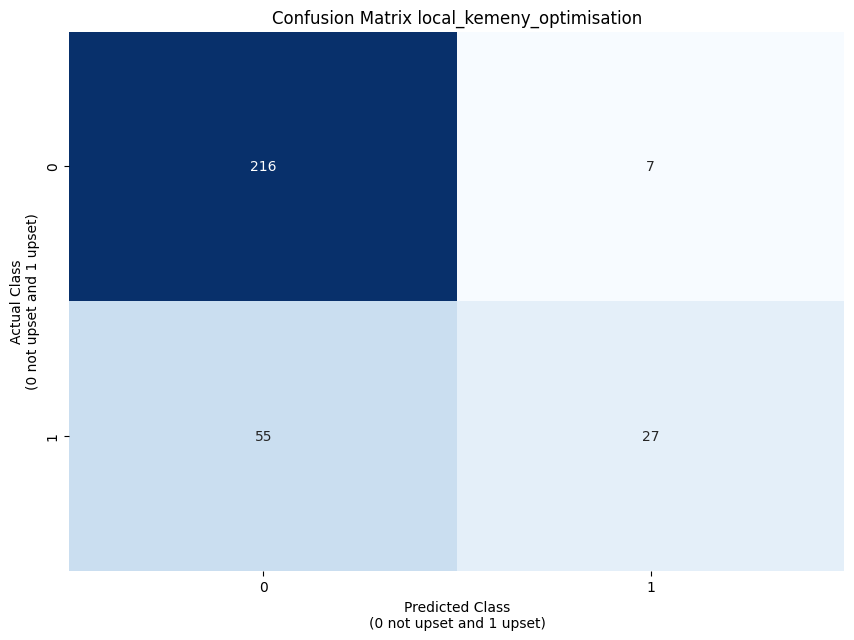

In [ ]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 687.82it/s]


In [ ]:
import pandas as pd

# Step 4: Group by home and away team levels and calculate win percentages
result = fa_cup_scores_df.groupby(['home_team_league_level', 'away_team_league_level']).agg({
    'home_win': 'mean',
    'away_win': 'mean',
}).reset_index()

# Step 5: Rename columns for clarity
result.columns = ['home_team_level', 'away_team_level', 'home_win_factor', 'away_win_factor']

# Step 6: Round percentages to 2 decimal places
result[['home_win_factor', 'away_win_factor']] = result[['home_win_factor', 'away_win_factor']].round(3)

# Display the result
print(result)

# Merge the result back to fa_cup_scores_df
fa_cup_scores_df_with_pct = fa_cup_scores_df.merge(
    result,
    left_on=['home_team_league_level', 'away_team_league_level'],
    right_on=['home_team_level', 'away_team_level'],
    how='left'
)

# Drop redundant columns
fa_cup_scores_df_with_pct = fa_cup_scores_df_with_pct.drop(columns=['home_team_level', 'away_team_level'])
display(fa_cup_scores_df_with_pct)


    home_team_level  away_team_level  home_win_factor  away_win_factor
0                 1                2            0.842            0.158
1                 1                3            0.846            0.154
2                 1                4            0.917            0.083
3                 1                5              1.0              0.0
4                 2                1            0.176            0.824
5                 2                3            0.514            0.486
6                 2                4            0.867            0.133
7                 2                5            0.833            0.167
8                 2                6              1.0              0.0
9                 3                1            0.389            0.611
10                3                2              0.5              0.5
11                3                4              0.5              0.5
12                3                5              0.5              0.5
13    

,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count,home_win_factor,away_win_factor
0,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1,0.176,0.824
1,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1,0.842,0.158
2,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1,0.842,0.158
3,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1,0.846,0.154
4,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1,0.842,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,475990,2010-01-19,58,Accrington Stanley,4,1,54,Gillingham,3,0,58,54,1,0,1,54,1,0.5,0.5
301,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1,0.5,0.5
302,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1,1.0,0.0
303,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1,1.0,0.0
